# TUTORIAL: MANEJO DE DATOS CATEGÓRICOS FALTANTES

En este tutorial veremos qué son y cómo implementar los diferentes métodos para realizar el manejo de datos faltantes cuando la variable de interés es categórica.

## 1. El set de datos

Usaremos un set de datos que contiene la información del sexo, el peso (en Kg) y la altura de un grupo de 600 personas:

In [1]:
# Importar librerías
import pandas as pd
import seaborn as sns

# Lectura
from google.colab import drive
drive.mount('/gdrive')

ruta = "/gdrive/MyDrive/02-CODIFICANDOBITS.COM/04-Academia/02-Tutoriales/pandas-manejo-datos-faltantes-categoricos/code/"
datos = pd.read_csv(ruta + 'dataset_datos_faltantes_categoricos.csv')
datos

Mounted at /gdrive


,sexo,peso (kg),altura (cm)
0,femenino,60.0,160.0
1,masculino,69.0,170.0
2,masculino,73.0,167.0
3,NaN,81.0,170.0
4,masculino,80.0,170.0
...,...,...,...
595,femenino,65.0,164.0
596,femenino,63.0,160.0
597,masculino,70.0,163.0
598,masculino,75.0,169.0


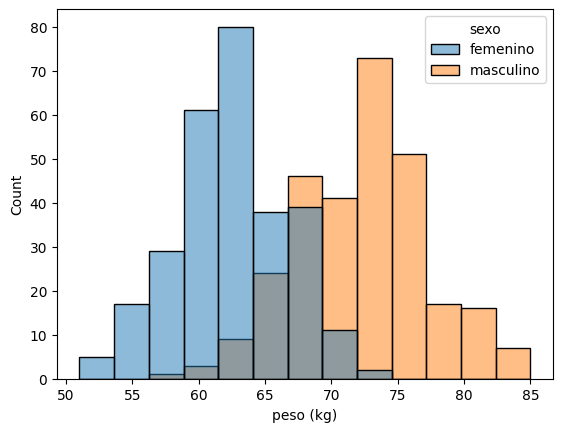

In [2]:
# Veamos la distribución de estos datos para el peso
sns.histplot(data=datos, x='peso (kg)', hue='sexo');

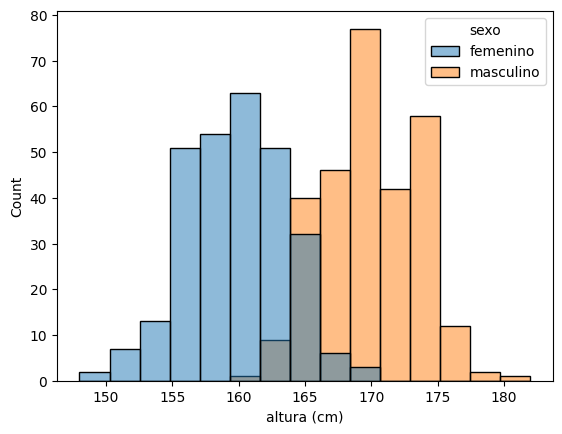

In [3]:
# Y ahora para la altura
sns.histplot(data=datos, x='altura (cm)', hue='sexo');

Y podemos verificar si hay datos faltantes de varias formas.

La primera es con el método `info()`:

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sexo         570 non-null    object 
 1   peso (kg)    600 non-null    float64
 2   altura (cm)  600 non-null    float64
dtypes: float64(2), object(1)
memory usage: 14.2+ KB


Vemos que:

- En total debería haber 600 datos
- La columna `sexo` es categórica (`masculino` o `femenino`) y contiene 570 registros. Es decir, **faltan 30 registros**.
- Las columnas `peso (kg)` y `altura (cm)` son numéricas y están completas

Otra forma de ver la cantidad de datos faltantes es usando `isna()` y `sum()`:

In [5]:
# Mostrar la cantidad de datos faltantes (marcados como NaN) en cada columna
datos.isna().sum()

sexo           30
peso (kg)       0
altura (cm)     0
dtype: int64

O también podemos usar `value_counts()` aplicado directamente sobre la columna `sexo`:

In [6]:
# Podemos verificar que la suma no es igual a 600
datos['sexo'].value_counts()

masculino    288
femenino     282
Name: sexo, dtype: int64

## 2. Formas de manejar datos faltantes para variables categóricas

Cuando la variable "problemática" es categórica (como el caso de la columna `sexo`) podemos usar alguno de estos enfoques:

1. Eliminar las filas con los registros faltantes
2. Eliminar la columna "problemática"
3. Imputar con la categoría más frecuente
4. Imputar usando *Machine Learning* (**recomendado**)

Veamos cada una de estas técnicas junto con sus ventajas y desventajas:

### 2.1. Eliminar filas con los registros faltantes

Consiste simplemente en quitar la fila completa para cada registro faltante.

- Ventaja: ¡es el método más simple!
- Desventajas:
  - Si el dataset es "pequeño" la eliminación puede reducir significativamente su tamaño
  - Lo anterior puede dificultar tareas posteriores como, por ejemplo, el uso de modelos de *Machine Learning* para generar predicciones

En el caso que nos interesa esta eliminación implica que por cada fila donde falta el dato del `sexo` también eliminaremos la información correspondiente a las columnas `peso (kg)` y `altura (cm)`.

La eliminación se puede hacer con el método `dropna()` de Pandas, que permite eliminar los registros que contienen datos *NaN*:

In [7]:
df_filas = datos.dropna(axis=0) # Axis = 0: eliminar filas
df_filas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 0 to 599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sexo         570 non-null    object 
 1   peso (kg)    570 non-null    float64
 2   altura (cm)  570 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.8+ KB


Ya no tenemos datos faltantes pero hemos pasado de 600 a 570 registros en total 🤨.

### 2.2. Eliminar columnas con los registros faltantes

Consiste simplemente en quitar la columna "problemática":

- Ventaja: ¡es el método más simple!
- Desventajas:
  - La eliminación de la columna "problema" puede dificultar tareas posteriores
  - ¿Vale la pena eliminar toda una columna cuando tan sólo faltan unos cuantos datos?

De nuevo, podemos usar el método `dropna()`:

In [8]:
df_cols = datos.dropna(axis=1) # Axis = 1: eliminar columna(s)
df_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   peso (kg)    600 non-null    float64
 1   altura (cm)  600 non-null    float64
dtypes: float64(2)
memory usage: 9.5 KB


Hemos preservado los 600 registros pero hemos eliminado una columna completa 🤨

### 2.3. Imputar con la categoría más frecuente

Consiste en encontrar, en la columna "problema", la categoría (o nivel) que ocurre con mayor frecuencia y usarla para completar los datos faltantes.

Por ejemplo, veamos la categoría más común en la columna `sexo`:

In [9]:
datos['sexo'].value_counts()

masculino    288
femenino     282
Name: sexo, dtype: int64

La categoría más común es `masculino` (288 datos en total). Así que en esta técnica de imputación usaríamos esta categoría para completar los datos faltantes.

- Ventaja: no se eliminan ni filas ni columnas.
- Desventaja: esta imputación puede generar sesgos

Para realizar esta imputación podemos usar el método `fillna()` de Pandas que nos permite "rellenar" los *NaN* con el valor que especifiquemos:

In [10]:
# Generar una copia del DataFrame original
df_frec = datos.copy()

# Tomar la columna "sexo" y usar "fillna" para rellenar los valores
# faltantes con la categoría "masculino"
df_frec['sexo'] = df_frec['sexo'].fillna('masculino')

# Verificar que ya no hay valores faltantes
df_frec['sexo'].isna().sum()

0

In [11]:
df_frec

,sexo,peso (kg),altura (cm)
0,femenino,60.0,160.0
1,masculino,69.0,170.0
2,masculino,73.0,167.0
3,masculino,81.0,170.0
4,masculino,80.0,170.0
...,...,...,...
595,femenino,65.0,164.0
596,femenino,63.0,160.0
597,masculino,70.0,163.0
598,masculino,75.0,169.0


### 2.4. Imputar usando *Machine Learning*

Es el método **más robusto y más recomendado**.

Consiste en construir un modelo de *Machine Learning* que tome las variables que están completas (por ejemplo `peso (kg)` y `altura (cm)`) y aprenda a predecir la variable incompleta (en este caso `sexo`):

![](https://drive.google.com/uc?export=view&id=1FPhsrSLu5TlHSoDtNSRgjMpxc7rD4qsa)


**Ventajas**
- Se preserva la cantidad de datos
- No se generan sesgos (siempre y cuando el modelo pueda ser construido correctamente)

**Desventajas**
- Se requieren suficientes datos para entrenar el modelo: no debe haber demasiados datos faltantes ni muy pocos datos de entrenamiento
- Dependiendo del set de datos no siempre resulta sencillo construir un modelo que genere predicciones adecuadas

**Procedimiento paso a paso**
1. Crear el set de entrenamiento: registros que contienen datos completos
2. Crear el set de prueba: registros que contienen datos incompletos
3. Escoger y entrenar el modelo de *Machine Learning* con el set de entrenamiento
4. Predecir datos faltantes con el modelo entrenado y con el set de prueba
5. Incorporar los datos predichos en el dataset

Veamos en este ejemplo cómo implementar cada paso:

In [12]:
# 1. Crear el set de entrenamiento

# 1.1. Extraer las filas que contienen datos completos
XY = datos.dropna().to_numpy()
XY.shape

(570, 3)

In [13]:
# 1.2. Set de entrenamiento
# x_train: columnas 1 y 2 ("peso (kg)" y "altura (cm)")
# y_train: columna 0 ("sexo")
x_train = XY[:,1:3]
y_train = XY[:,0]

print(x_train)
print(y_train)

[[60.0 160.0]
 [69.0 170.0]
 [73.0 167.0]
 ...
 [70.0 163.0]
 [75.0 169.0]
 [66.0 157.0]]
['femenino' 'masculino' 'masculino' 'masculino' 'femenino' 'femenino'
 'femenino' 'femenino' 'femenino' 'femenino' 'femenino' 'masculino'
 'masculino' 'femenino' 'femenino' 'femenino' 'masculino' 'femenino'
 'femenino' 'masculino' 'femenino' 'femenino' 'masculino' 'masculino'
 'femenino' 'masculino' 'femenino' 'femenino' 'masculino' 'masculino'
 'masculino' 'femenino' 'femenino' 'masculino' 'masculino' 'masculino'
 'masculino' 'masculino' 'masculino' 'masculino' 'femenino' 'masculino'
 'femenino' 'femenino' 'masculino' 'masculino' 'masculino' 'femenino'
 'femenino' 'masculino' 'femenino' 'masculino' 'femenino' 'femenino'
 'femenino' 'masculino' 'masculino' 'masculino' 'masculino' 'femenino'
 'masculino' 'masculino' 'masculino' 'masculino' 'masculino' 'masculino'
 'masculino' 'masculino' 'femenino' 'femenino' 'masculino' 'femenino'
 'masculino' 'femenino' 'femenino' 'masculino' 'masculino' 'masculi

In [14]:
# 2. Crear el set de prueba: filas con datos incompletos
# y columnas "peso (kg)" y "altura (cm)"

filas = datos[~datos['sexo'].notna()].index # Filas incompletas
x_test = datos[['peso (kg)', 'altura (cm)']].iloc[filas].to_numpy()
x_test

array([[ 81., 170.],
       [ 68., 166.],
       [ 62., 164.],
       [ 63., 153.],
       [ 57., 155.],
       [ 63., 163.],
       [ 73., 176.],
       [ 64., 167.],
       [ 71., 168.],
       [ 80., 163.],
       [ 69., 157.],
       [ 58., 167.],
       [ 72., 173.],
       [ 62., 159.],
       [ 66., 155.],
       [ 66., 162.],
       [ 58., 161.],
       [ 87., 171.],
       [ 68., 169.],
       [ 67., 161.],
       [ 58., 160.],
       [ 62., 155.],
       [ 63., 153.],
       [ 70., 166.],
       [ 60., 162.],
       [ 65., 159.],
       [ 71., 169.],
       [ 70., 172.],
       [ 63., 165.],
       [ 63., 164.]])

El tercer paso es escoger y entrenar el modelo de Machine Learning con el set de entrenamiento.

Para este ejemplo podemos usar un sencillo modelo de Regresión Logística.

Pero antes de entrenarlo debemos pre-procesar los datos, pues las categorías a predecir (`masculino`, `femenino`) no pueden estar en formato de texto sino que deben estar en formato numérico (0 ó 1).

Para hacer esta conversión podemos usar `LabelEncoder` de *Scikit Learn*:

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
le.classes_

array(['femenino', 'masculino'], dtype=object)

In [16]:
# Y ahora convertimos "y_train" a representación numérica
y_train = le.transform(y_train)
y_train

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,

In [17]:
# Después de construir el modelo, este generará predicciones
# numéricas (0, 1). Para obtener la categoría correspondiente
# usamos "inverse_transform". Por ejemplo:
le.inverse_transform([0,1,1,0])

array(['femenino', 'masculino', 'masculino', 'femenino'], dtype=object)

¡Muy bien! Con los datos pre-procesados podemos construir y entrenar el modelo usando el módulo `LogisticRegression` de *Scikit Learn*:

In [18]:
# Importar el módulo
from sklearn.linear_model import LogisticRegression

# Crear instancia del modelo
lr = LogisticRegression()

# Entrenarlo con "fit" y con los datos de entrenamiento
lr.fit(x_train,y_train)

LogisticRegression()

¡Y con pocas líneas de código ya tenemos entrenado este modelo!

Veamos un ejemplo de predicción para entender cómo usarlo:

In [19]:
entrada = [[69.,120.]]     # Supondremos un peso de 69 Kg y una altura de 120 cm
pred = lr.predict(entrada) # Generamos la predicción con predict
cat = le.inverse_transform(pred) # Y hacemos la transformación inversa

print(pred)
print(cat)

[0]
['femenino']


Ahora sólo debemos hacer lo mismo pero con el set de prueba (`x_test`) que, recordemos, es el que contiene los datos de peso y altura para las filas para las cuales desconocemos el sexo:

In [20]:
# Predicciones sobre el set de prueba
preds = lr.predict(x_test)
print(preds)

# Transformaciones inversas
cats = le.inverse_transform(preds)
print(cats)

[1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0]
['masculino' 'masculino' 'femenino' 'femenino' 'femenino' 'femenino'
 'masculino' 'masculino' 'masculino' 'masculino' 'femenino' 'femenino'
 'masculino' 'femenino' 'femenino' 'femenino' 'femenino' 'masculino'
 'masculino' 'femenino' 'femenino' 'femenino' 'femenino' 'masculino'
 'femenino' 'femenino' 'masculino' 'masculino' 'femenino' 'femenino']


¡¡¡Perfecto!!! Lo único que queda es tomar las predicciones que se encuentran en la lista `cats` y realizar la imputación:

In [21]:
# Ubicar las categorías predichas en las filas correspondientes
# de la columna "sexo" en el dataframe resultante
df_ml = datos.copy()
df_ml.iloc[filas,0]= cats # "sexo" es la columna 0
df_ml

,sexo,peso (kg),altura (cm)
0,femenino,60.0,160.0
1,masculino,69.0,170.0
2,masculino,73.0,167.0
3,masculino,81.0,170.0
4,masculino,80.0,170.0
...,...,...,...
595,femenino,65.0,164.0
596,femenino,63.0,160.0
597,masculino,70.0,163.0
598,masculino,75.0,169.0


In [22]:
# Y verifiquemos que no hay datos faltantes
df_ml['sexo'].isna().sum()

0